In [2]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tempfile
import imageio
from scipy import signal
from importlib import reload
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pylab as pl

# err budget calc

In [3]:
# givens
r_o = 0.16 # make a scale
v_wind = 18.7 # m/s
D_tel = 6.5 # m
n_act_acr = 39 # change this
n_act = n_act_acr**2 
t_int = 0.0005 #s
s_mag = 4
t_s_lag = 0.005 #s
lam_ro = 550 #nm
lam_wave = 810 # nm
ang_zenith = 0 #ang

In [4]:
# caluclations
airmass = 1 / np.cos(ang_zenith * np.pi / 180)
seeing_550 = 0.1/r_o
ro_scaled = r_o * (lam_wave / lam_ro)**(5/3) * airmass**(-3/5)
D_div_ro = D_tel / ro_scaled
frq_GW = 0.43 * v_wind / ro_scaled # f_o
act_acr_ap = 2*np.sqrt(n_act_acr/np.pi)
act_spacing = D_tel / act_acr_ap

In [5]:
# magnitude calc
mag0_flux = 452 # p / cm^2 / s / Ang
area = (D_tel*100)**2 * np.pi / 4 #cm^2
delt_lam = 3570 # ang
throughput = 0.1
photons = mag0_flux * area * delt_lam * throughput
phot_flux = photons*t_int*10**(-s_mag/2.5)

In [35]:
# Error Fitting
def calc_err_fit_rad(act_space, ro_scaled):
    err = 0.28 * (act_space / ro_scaled)**(5/3)
    return err**0.5

def calc_err_fit_nm(act_space, ro_scaled, lam_wave):
    err_rad = calc_err_fit_rad(act_space, ro_scaled)
    return lam_wave*err_rad / (2*np.pi)

# Error temporal
def calc_err_temp_rad(t_s_lag, f_o):
    err = (t_s_lag*f_o)**(5/3)
    return err**0.5

def calc_err_temp_nm(t_s_lag, t_o, lam_wave):
    err_rad = calc_err_temp_rad(t_s_lag, t_o)
    return lam_wave*err_rad / (2*np.pi)

# Error photon noise
def calc_err_phot_rad(n_act, phot_flux):
    # extra beta_p term from pywfs term
    beta_p =2*np.sqrt(2) 
    err = beta_p * n_act / phot_flux
    return err**0.5

def calc_err_phot_nm(n_act, phot_flux, lam_wave):
    err_rad = calc_err_phot_rad(n_act, phot_flux)
    return lam_wave*err_rad / (2*np.pi)

# Error from TT residuals
def calc_strehl_tt(rms_jitter, D_tel, lam_wave):
    k = 0.98 # from central obstruction
    coeff  =  8*np.log(2) / k**2
    psf_width_rad = (lam_wave*1e-9 /  D_tel)
    psf_width_mas  = psf_width_rad * 206265 * 1000
    gauss = rms_jitter / psf_width_mas
    denom = 1 + coeff*(gauss**2)
    return 1 / denom


0.5336423083240901

In [33]:
def ro_to_seeing_dumb(r_o):
    return 0.1/r_o

def ro_to_seeing(r_o, lamda=550):
    seeing_rad = 0.98*lamda*1e-9/r_o
    factor_as = 60*60*180/(np.pi) 
    factor = 206265
    return seeing_rad*factor

def seeing_to_r_o(seeing, lam_seeing=550):
    as_factor = 1/206265
    r_o = (0.98*lam_seeing*1e-9) / (as_factor*seeing)
    return r_o

In [47]:
def calc_strehl(s_mag=5, r_o=0.16, n_act_acr=39, t_int = 0.0005, err_NCPA_nm=23, rms_jitter = 10):
    # Inputs that are mostly constant:
    v_wind=15
    t_s_lag = 0.005 #s usually 10 time control loop speed, control bandwidth
    D_tel=6.5
    n_act = n_act_acr**2
    lam_ro = 550 #nm
    lam_wave = 810 # nm
    ang_zenith = 0 #ang
    # Caluclations
    airmass = 1 / np.cos(ang_zenith * np.pi / 180)
    seeing_550 = 0.1/r_o
    ro_scaled = r_o * (lam_wave / lam_ro)**(5/3) * airmass**(-3/5)
    D_div_ro = D_tel / ro_scaled
    frq_GW = 0.43 * v_wind / ro_scaled
    act_acr_ap = 2*np.sqrt(n_act/np.pi)
    act_spacing = D_tel / act_acr_ap
    # magnitude calc
    mag0_flux = 452 # p / cm^2 / s / Ang
    area = (D_tel*100)**2 * np.pi / 4 #cm^2
    delt_lam = 3570 # ang
    throughput = 0.1
    photons = mag0_flux * area * delt_lam * throughput
    phot_flux = photons*t_int*10**(-s_mag/2.5)
    # err in rad for strehl
    err_fit_rad = calc_err_fit_rad(act_spacing, ro_scaled)
    err_temp_rad = calc_err_temp_rad(t_s_lag, frq_GW)
    err_phot_rad = calc_err_phot_rad(n_act, phot_flux)
    # calc Strehl from rad err
    err_tot_sq = err_fit_rad**2 + err_temp_rad**2 + err_phot_rad**2
    strehl = np.exp(-err_tot_sq)
    strehl_tt = calc_strehl_tt(rms_jitter, D_tel, lam_wave)
    return strehl*strehl_tt


In [43]:
def calc_strehl_df(s_mag=5, r_o=0.16, n_act_acr=39, t_int = 0.0005, rms_jitter = 5):
    # Inputs that are mostly constant:
    v_wind = 15
    t_s_lag = 0.005 #s usually 10 time control loop speed, control bandwidth
    D_tel = 6.5
    n_act = n_act_acr**2
    lam_ro = 550 #nm
    lam_wave = 810 # nm
    ang_zenith = 0 #ang
    # Caluclations
    airmass = 1 / np.cos(ang_zenith * np.pi / 180)
    seeing_550 = 0.1/r_o
    ro_scaled = r_o * (lam_wave / lam_ro)**(5/3) * airmass**(-3/5)
    D_div_ro = D_tel / ro_scaled
    frq_GW = 0.43 * v_wind / ro_scaled
    act_acr_ap = 2*np.sqrt(n_act/np.pi)
    act_spacing = D_tel / act_acr_ap
    # magnitude calc
    mag0_flux = 452 # p / cm^2 / s / Ang
    area = (D_tel*100)**2 * np.pi / 4 #cm^2
    delt_lam = 3570 # ang
    throughput = 0.1
    photons = mag0_flux * area * delt_lam * throughput
    phot_flux = photons*t_int*10**(-s_mag/2.5)
    # err in rad for strehl
    err_fit_rad = calc_err_fit_rad(act_spacing, ro_scaled)
    err_fit_nm = calc_err_fit_nm(act_spacing, ro_scaled, lam_wave)
    err_temp_rad = calc_err_temp_rad(t_s_lag, frq_GW)
    err_temp_nm = calc_err_temp_nm(t_s_lag, frq_GW, lam_wave)
    err_phot_rad = calc_err_phot_rad(n_act, phot_flux)
    err_phot_nm = calc_err_phot_nm(n_act, phot_flux, lam_wave)
    # calc Strehl from rad err
    err_tot_sq = err_fit_rad**2 + err_temp_rad**2 + err_phot_rad**2 
    strehl = np.exp(-err_tot_sq)
    strehl_tt = calc_strehl_tt(rms_jitter, D_tel, lam_wave)
    return [strehl, strehl_tt, strehl*strehl_tt, r_o, ro_scaled, err_fit_rad, err_temp_rad, err_phot_rad, err_fit_nm, err_temp_nm, err_phot_nm, s_mag, phot_flux,  n_act, n_act_acr, act_acr_ap, act_spacing, t_int, t_s_lag, v_wind, frq_GW, lam_ro, lam_wave]

In [44]:
columns = ["SR_er", "SR_tt", "SR", "ro", "ro_scaled", "err_fit", "err_temp", "err_phot", "err_fit_nm", "err_temp_nm", "err_phot_nm", "mag", "phot_flux", "n_act", "n_act_across", "act_across_ap", "act_spacing", "t_int", "t_s_lag", "v_wind", "GW_frq", "wavelegth_ro", "wavelength_wfs"]

DIMM_list = np.arange(.25, 1.5, 0.05)
r_o_list = seeing_to_r_o(DIMM_list)
strehl_big_list = [calc_strehl_df(r_o = r_i) for r_i in r_o_list]


In [38]:
strehl_big_df = pd.DataFrame(strehl_big_list, columns = columns)

In [23]:
strehl_big_df.to_csv("err_budget_example.csv", sep='\t')

In [39]:
strehl_big_df

,SR_er,SR_tt,SR,ro,ro_scaled,err_fit,err_temp,err_phot,err_fit_nm,err_temp_nm,...,n_act,n_act_across,act_across_ap,act_spacing,t_int,t_s_lag,v_wind,GW_frq,wavelegth_ro,wavelength_wfs
0,0.965037,0.533642,0.514984,0.444707,0.847770,0.123360,0.065596,0.126762,15.903050,8.456320,...,1521,39,44.006788,0.147704,0.0005,0.005,15,7.608193,550,810
1,0.958370,0.533642,0.511427,0.370589,0.706475,0.143602,0.076359,0.126762,18.512488,9.843869,...,1521,39,44.006788,0.147704,0.0005,0.005,15,9.129832,550,810
2,0.950973,0.533642,0.507479,0.317648,0.605550,0.163286,0.086826,0.126762,21.050082,11.193214,...,1521,39,44.006788,0.147704,0.0005,0.005,15,10.651471,550,810
3,0.942900,0.533642,0.503171,0.277942,0.529856,0.182505,0.097046,0.126762,23.527751,12.510694,...,1521,39,44.006788,0.147704,0.0005,0.005,15,12.173109,550,810
4,0.934203,0.533642,0.498530,0.247060,0.470983,0.201327,0.107054,0.126762,25.954192,13.800935,...,1521,39,44.006788,0.147704,0.0005,0.005,15,13.694748,550,810
5,0.924925,0.533642,0.493579,0.222354,0.423885,0.219803,0.116878,0.126762,28.336014,15.067450,...,1521,39,44.006788,0.147704,0.0005,0.005,15,15.216386,550,810
6,0.915109,0.533642,0.488341,0.202140,0.385350,0.237973,0.126540,0.126762,30.678397,16.312994,...,1521,39,44.006788,0.147704,0.0005,0.005,15,16.738025,550,810
7,0.904793,0.533642,0.482836,0.185295,0.353238,0.255869,0.136056,0.126762,32.985504,17.539780,...,1521,39,44.006788,0.147704,0.0005,0.005,15,18.259664,550,810
8,0.894014,0.533642,0.477084,0.171041,0.326065,0.273518,0.145441,0.126762,35.260750,18.749624,...,1521,39,44.006788,0.147704,0.0005,0.005,15,19.781302,550,810
9,0.882806,0.533642,0.471102,0.158824,0.302775,0.290942,0.154706,0.126762,37.506982,19.944040,...,1521,39,44.006788,0.147704,0.0005,0.005,15,21.302941,550,810


In [74]:
print(ro_to_seeing_dumb(ro_list))

[2.         1.66666667 1.42857143 1.25       1.11111111 1.
 0.90909091 0.83333333 0.76923077 0.71428571 0.66666667 0.625
 0.58823529 0.55555556 0.52631579 0.5        0.47619048 0.45454545
 0.43478261 0.41666667 0.4        0.38461538 0.37037037 0.35714286
 0.34482759 0.33333333 0.32258065 0.3125     0.3030303  0.29411765
 0.28571429 0.27777778 0.27027027 0.26315789 0.25641026]


In [79]:
print(ro_to_seeing(ro_list))

[2.2235367  1.85294725 1.5882405  1.38971044 1.23529817 1.11176835
 1.0106985  0.92647362 0.85520642 0.79412025 0.7411789  0.69485522
 0.65398138 0.61764908 0.58514124 0.55588417 0.5294135  0.50534925
 0.48337754 0.46323681 0.44470734 0.42760321 0.41176606 0.39706012
 0.3833684  0.37058945 0.35863495 0.34742761 0.3368995  0.32699069
 0.3176481  0.30882454 0.30047793 0.29257062 0.28506881]


## First plot: Vary Control modes

seeing vs. Strehl, picking an average guide star of 5th mag

with or without added WFE resitudals

In [48]:
DIMM_list = np.arange(.25, 1.5, 0.05)
r_o_list = seeing_to_r_o(DIMM_list)
modal_control = [39, 32, 29, 27, 25, 21]
strehl_list = [[calc_strehl(r_o = r_i, n_act_acr = a) for r_i in r_o_list] for a in modal_control]
print(r_o_list)
print(strehl_list[0])

[0.44470734 0.37058945 0.3176481  0.27794209 0.24705963 0.22235367
 0.2021397  0.18529473 0.17104128 0.15882405 0.14823578 0.13897104
 0.13079628 0.12352982 0.11702825 0.11117684 0.1058827  0.10106985
 0.09667551 0.09264736 0.08894147 0.08552064 0.08235321 0.07941203
 0.07667368]
[0.5149843461727154, 0.5114270264163311, 0.5074793616895836, 0.5031714941955632, 0.4985300477115947, 0.49357910164615787, 0.4883408119532563, 0.4828358256930705, 0.4770835677390906, 0.47110244455642447, 0.4649099921867304, 0.4585229855685274, 0.45195752040907344, 0.44522907518361454, 0.43835255851641514, 0.4313423456721959, 0.4242123068569107, 0.4169758293154993, 0.4096458347126284, 0.4022347929220236, 0.3947547330866856, 0.3872172526169481, 0.3796335246464144, 0.372014304353887, 0.3643699344731427]


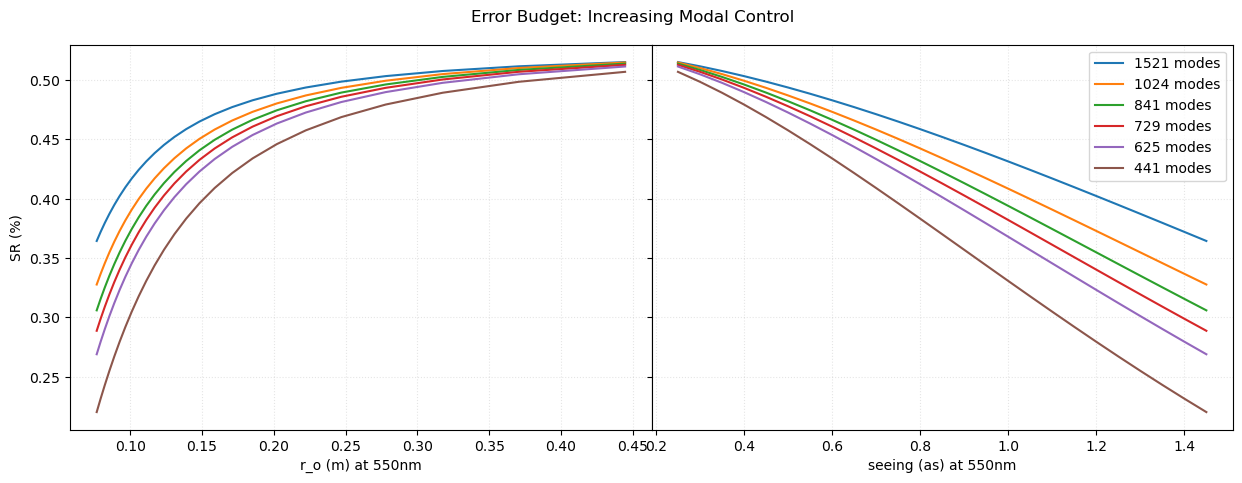

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5), facecolor='white', sharey=True)
fig.suptitle("Error Budget: Increasing Modal Control", y = 0.95)
fig.subplots_adjust(wspace=0, hspace = 0)

axs[0].grid(color='grey', linestyle=':', alpha=0.2)
axs[1].grid(color='grey', linestyle=':', alpha=0.2)
for i in range(len(modal_control)):
    axs[0].plot(r_o_list, strehl_list[i], label = f"{modal_control[i]**2} modes")
    axs[0].set_xlabel('r_o (m) at 550nm')

for i in range(len(modal_control)):
    axs[1].plot(DIMM_list, strehl_list[i], label = f"{modal_control[i]**2} modes")
    axs[1].set_xlabel('seeing (as) at 550nm')

axs[0].set_ylabel('SR (%)')
axs[1].legend()

plt.show()

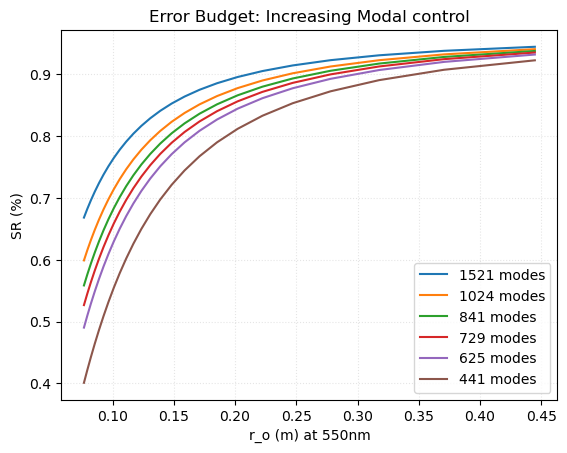

In [33]:
plt.title("Error Budget: Increasing Modal control")
plt.xlabel('r_o (m) at 550nm')
plt.ylabel('SR (%)')
plt.grid(color='grey', linestyle=':', alpha=0.2)
for i in range(len(modal_control)):
    plt.plot(r_o_list, strehl_list[i], label = f"{modal_control[i]**2} modes")
plt.legend()

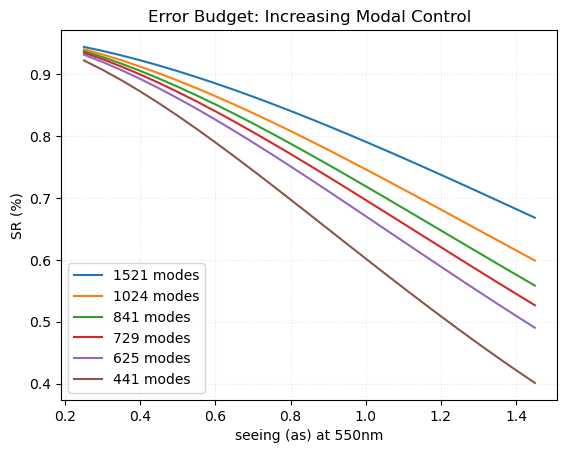

In [32]:
# same plot but with seeing as in DIMM (as)
plt.title("Error Budget: Increasing Modal Control")
plt.xlabel('seeing (as) at 550nm')
plt.ylabel('SR (%)')
plt.grid(color='grey', linestyle=':', alpha=0.2)
for i in range(len(modal_control)):
    plt.plot(DIMM_list, strehl_list[i], label = f"{modal_control[i]**2} modes")
plt.legend()
plt.show()


## Second Plot: Vary guide star magnitude

In [23]:
DIMM_list = np.arange(.25, 1.5, 0.05)
r_o_list = seeing_to_r_o(DIMM_list) # in meters
mags_list = np.arange(2, 11, 1)
strehl_list = [[calc_strehl(r_o = r_i, s_mag = m) for r_i in r_o_list] for m in mags_list]

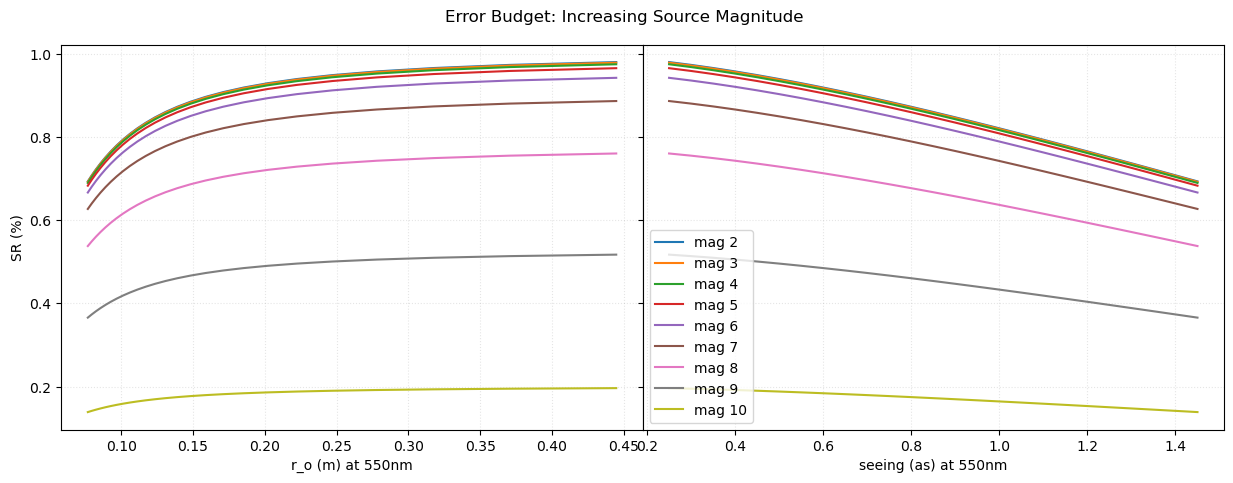

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5), facecolor='white', sharey=True)
fig.suptitle("Error Budget: Increasing Source Magnitude", y = 0.95)
fig.subplots_adjust(wspace=0, hspace = 0)

axs[0].grid(color='grey', linestyle=':', alpha=0.2)
axs[1].grid(color='grey', linestyle=':', alpha=0.2)
for i in range(len(mags_list)):
    axs[0].plot(r_o_list, strehl_list[i], label = f"mag {mags_list[i]}")
    axs[0].set_xlabel('r_o (m) at 550nm')

for i in range(len(mags_list)):
    axs[1].plot(DIMM_list, strehl_list[i], label = f"mag {mags_list[i]}")
    axs[1].set_xlabel('seeing (as) at 550nm')

axs[0].set_ylabel('SR (%)')
axs[1].legend()

plt.show()

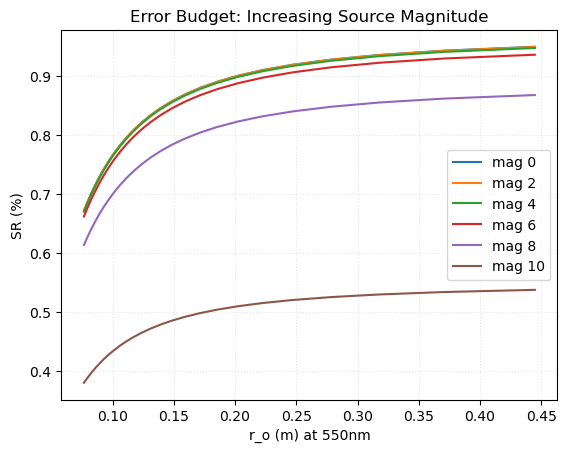

In [36]:
plt.title("Error Budget: Increasing Source Magnitude")
plt.xlabel('r_o (m) at 550nm')
plt.ylabel('SR (%)')
plt.grid(color='grey', linestyle=':', alpha=0.2)
for i in range(len(mags_list)):
    plt.plot(r_o_list, strehl_list[i], label = f"mag {mags_list[i]}")
plt.legend()

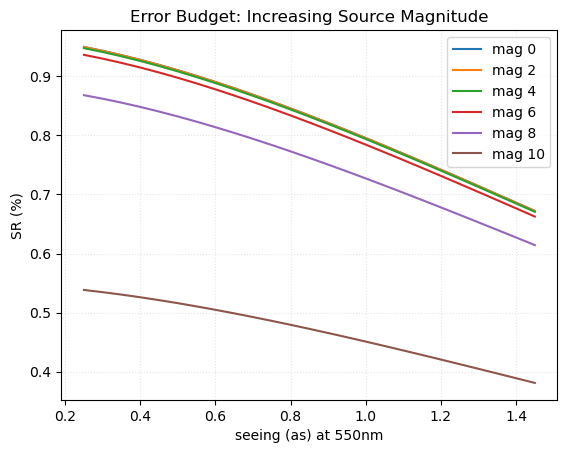

In [38]:
# same plot but with seeing as in DIMM (as)
plt.title("Error Budget: Increasing Source Magnitude")
plt.xlabel('seeing (as) at 550nm')
plt.ylabel('SR (%)')
plt.grid(color='grey', linestyle=':', alpha=0.2)
for i in range(len(modal_control)):
    plt.plot(DIMM_list, strehl_list[i], label = f"mag {mags_list[i]}")
plt.legend()